In [9]:
%pip install matplotlib numpy

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 2.5 MB/s eta 0:00:00a 0:00:010m
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 6.6 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import re
import inflect

# Initialize the number-to-words engine
p = inflect.engine()

In [ ]:
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

# Load the metadata
metadata_path = "../data/metadata.csv"
df = pd.read_csv(metadata_path)

print(f"Loaded metadata with {len(df)} samples.")

Loaded metadata with 2703 samples.


In [36]:
def normalize_text(text: str) -> str:
    """
    Normalizes a string of text for TTS processing.
    """
    text = text.lower()
    
    # Expand numbers to words
    text = re.sub(r"(\d+)", lambda m: p.number_to_words(m.group(0)), text)
    
    # Expand common abbreviations
    abbreviations = {
        "mr.": "mister",
        "mrs.": "missis",
        "dr.": "doctor",
        "etc.": "et cetera",
    }
    for abbr, expansion in abbreviations.items():
        text = text.replace(abbr, expansion)
        
    # --- THIS IS THE NEW, FIXED STEP ---
    # Replace punctuation that should be a space (like periods or commas) with a space
    text = re.sub(r'[.,]', ' ', text)
    
    # Remove any remaining non-alphanumeric/non-space characters (like '$')
    text = re.sub(r'[^\w\s]', '', text)
    
    # Collapse multiple spaces into one and strip leading/trailing space
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [55]:
# Get a new random sample to see different results
sample = df.sample(n=1).iloc[0]
original_text = sample["text"]

# Normalize the text
normalized_text = normalize_text(original_text)

# Print the before and after
print("Original text:")
print(original_text)
print("\nNormalized text:")
print(normalized_text)

Original text:
ILLUSTRATION BUNS

Normalized text:
illustration buns


In [33]:
import librosa
import numpy as np

# These are standard hyperparameters for a Tacotron-style model
SAMPLING_RATE = 22050
N_FFT = 1024
HOP_LENGTH = 256
WIN_LENGTH = 1024
N_MELS = 80
FMIN = 0
FMAX = 8000


In [34]:
def get_mel_spectrogram(filepath):
    """
    Converts an audio file into a mel spectrogram.
    
    This function performs the following steps:
    1. Loads the audio file and resamples it to a standard rate.
    2. Computes the mel spectrogram.
    3. Converts the spectrogram to a logarithmic scale (decibels).
    """
    # Load the audio, resampling to our standard rate
    y, sr = librosa.load(filepath, sr=SAMPLING_RATE)
    
    # Compute the mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH,
        n_mels=N_MELS,
        fmin=FMIN,
        fmax=FMAX
    )
    
    # Convert the power spectrogram to decibels
    # This is a log-scale representation which is closer to human perception
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    return mel_spec_db

Shape of the mel spectrogram: (80, 254)


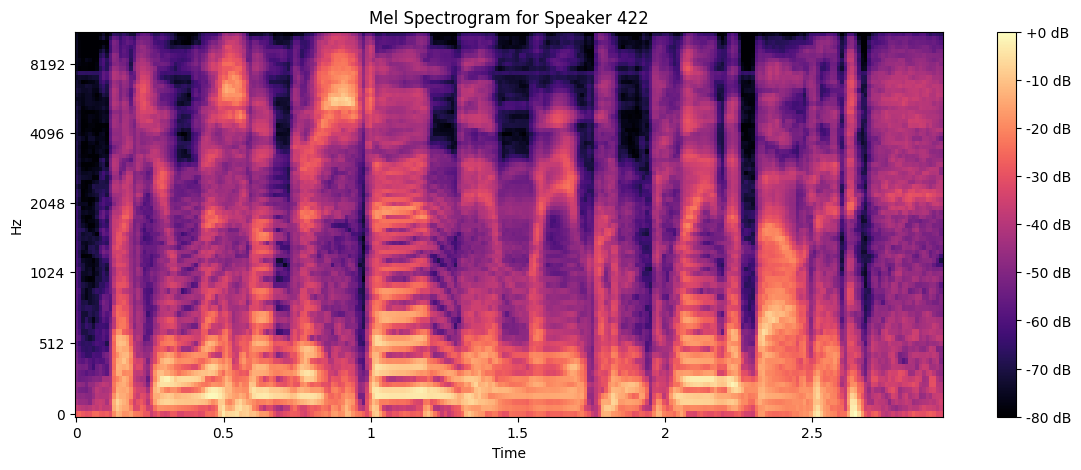

In [35]:
# Get the filepath from our sample
filepath = sample["filepath"]

# Generate the mel spectrogram
mel_spectrogram = get_mel_spectrogram(filepath)

print(f"Shape of the mel spectrogram: {mel_spectrogram.shape}")

# Plot the mel spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_spectrogram, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram for Speaker {sample["speaker_id"]}')
plt.show()